In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import logging
import datetime

nblog = open("tree_ml_ale_shap_"+str(datetime.datetime.now()).split(' ')[0]+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
df_localness = pd.read_csv('./food_localness_with_entropy_oct.csv')
print(df_localness.shape[0])

2887183


In [31]:
df_localness.head(2)

,account_id,order_id,order_date,order_time,vendor_id,vendor_name,main_cuisine,vertical,delivery_fee_amount_lc,service_fee_amount_lc,basket_amount_lc,is_incentive_applied,incentive_amount_lc,pickup_id,customer_lon,customer_lat,vendor_lon,vendor_lat,order_time_hour,delivery_duration,total_duration,customer_geometry,vendor_geometry,order_distance_km,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,nearest_euc_distance,localness,customer_loc_id,entropy_3.6km,item_price,compensation,discounted delivery,free delivery,gem,item discount,menu discount,voucher wallet,appoxi_rent,entropy_2km,entropy_0.3km,isweekend
0,4285647,1305786978,2023-10-10,2023-10-10 18:37:22,15921,"312 , Al Sufouh 1",american,food,9.0,2.36,78.5,0,0.0,249215302.0,55.22939,25.164577,55.175844,25.107854,18,37,54,POINT (6148107.571623116 2895972.7784882844),POINT (6142146.858169098 2888997.883505384),9.174926,food,702934,american,"My Hot Dog, Jumeirah 3",55.221344,25.176179,1.684822,0.183633,55.2293925.164577,0.670995,26.679487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.209394,0.625864,0.000000,False
1,1349127,1305612765,2023-10-10,2023-10-10 16:02:54,702587,"Subz, Business Bay",american,food,5.0,2.34,78.0,True,30.0,249170878.0,55.27096,25.180780,55.269598,25.188222,16,10,32,POINT (6152735.122855392 2897965.761873224),POINT (6152583.494576982 2898881.161766449),0.927873,food,702037,american,"Burger Basics, Business Bay",55.275506,25.180872,0.506177,0.545524,55.2709625.18078,0.744623,37.650000,0.0,0.0,0.0,0.0,0.0,30.0,0.0,95.263292,0.753064,0.414145,False


In [38]:
df_localness.dtypes

account_id                int64   
order_id                  int64   
order_date                object  
order_time                object  
vendor_id                 int64   
vendor_name               object  
main_cuisine              category
vertical                  object  
delivery_fee_amount_lc    float64 
service_fee_amount_lc     float64 
basket_amount_lc          float64 
is_incentive_applied      object  
incentive_amount_lc       float64 
pickup_id                 float64 
customer_lon              float64 
customer_lat              float64 
vendor_lon                float64 
vendor_lat                float64 
order_time_hour           int64   
delivery_duration         int64   
total_duration            int64   
customer_geometry         object  
vendor_geometry           object  
order_distance_km         float64 
n_vertical                object  
n_vendor_id               int64   
n_main_cuisine            object  
n_vendor_name             object  
n_vendor_lon        

In [37]:
df_localness["isweekend"] = df_localness["isweekend"].astype("category")
df_localness["main_cuisine"] = df_localness["main_cuisine"].astype("category")

In [39]:
df_features = df_localness[['basket_amount_lc','item_price','order_time_hour','total_duration',
                            'appoxi_rent', 'entropy_3.6km','entropy_2km','entropy_0.3km',
                            'incentive_amount_lc','isweekend','main_cuisine']]

In [40]:
X = df_features
y = df_localness.localness

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [8]:
import xgboost as xgb
import multiprocessing
from sklearn.model_selection import GridSearchCV

In [43]:
%%time

regressor=xgb.XGBRegressor(
    eval_metric = 'rmse',
    tree_method='gpu_hist',
    enable_categorical=True,
    n_gpus = -1,
    device="cuda"
)
regressor.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)], verbose=False) 
# early_stopping_rounds to avoid overfitting

[17:01:38] WARNING: ../src/learner.cc:627: 
Parameters: { "device", "n_gpus" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: user 9.77 s, sys: 892 ms, total: 10.7 s
Wall time: 2.93 s


In [44]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print('Best Model R-squared: %.3f' % r2)
# RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred) )
# print("Best Model RMSLE: %.3f" % RMSLE )
###**** old output based on GridSearch best model
# Best Model RMSE: 0.255
# Best Model R-squared: 0.284
# CPU times: user 27.7 s, sys: 185 ms, total: 27.8 s

Best Model RMSE: 0.239
Best Model R-squared: 0.372
CPU times: user 6.11 s, sys: 91 ms, total: 6.2 s
Wall time: 469 ms


# Feature importance

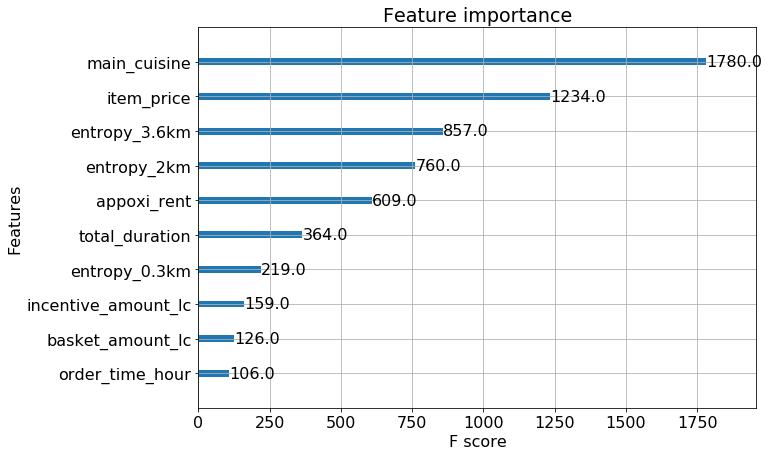

In [61]:
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(10,7))
# plot_importance(regressor, ax=ax, max_num_features=10) # top 10 most important features
plot_importance(regressor, ax=ax, max_num_features=10, importance_type='weight') #weight, gain, cover 
# compute feature importance based on the training data
plt.show()

## PDP

2024-05-28 13:11:04.798809 *************** Start running PDP ***************
2024-05-28 13:41:21.520906 *************** Done running PDP ***************
CPU times: user 3h 20min 30s, sys: 12min 10s, total: 3h 32min 41s
Wall time: 30min 16s


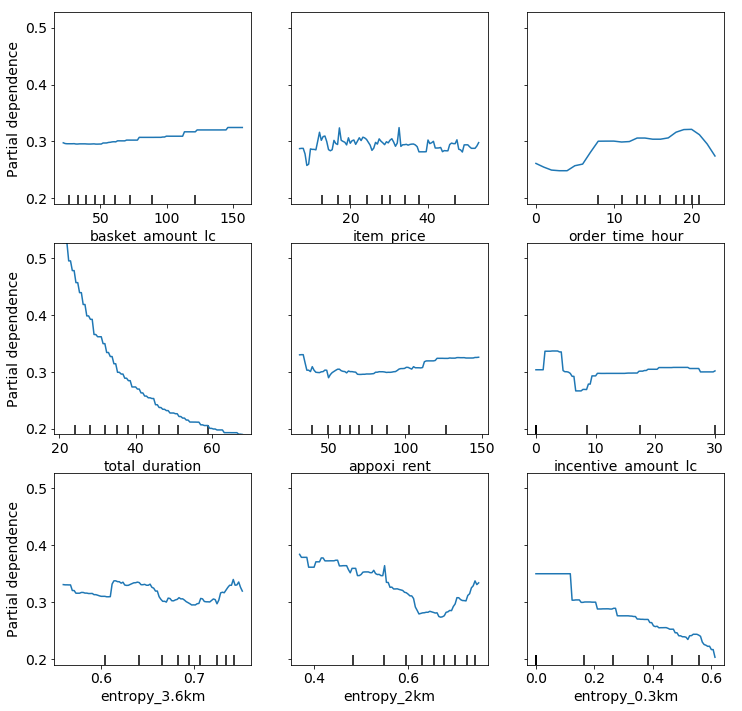

In [62]:
%%time 
# takes ~ 14min in total
print(datetime.datetime.now(),'*************** Start running PDP ***************')
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12, 12))
tree_disp = PartialDependenceDisplay.from_estimator(
    regressor, X, ['basket_amount_lc','item_price','order_time_hour','total_duration',
                            'appoxi_rent','incentive_amount_lc','entropy_3.6km','entropy_2km','entropy_0.3km'
                            ], ax=ax)
print(datetime.datetime.now(),'*************** Done running PDP ***************')

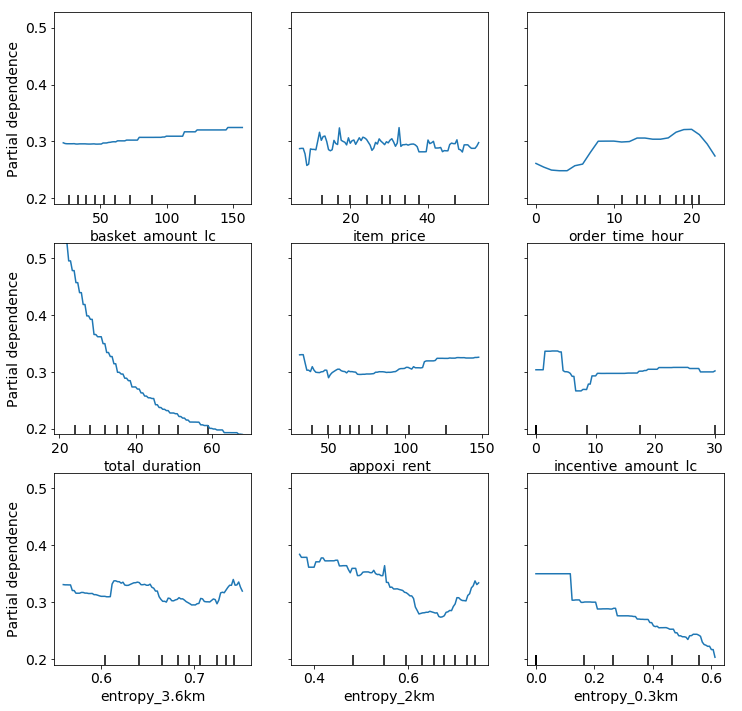

In [67]:
#resize figure
plt.rcParams.update({'font.size': 14})
fig2, ax2 = plt.subplots(figsize=(12, 12))
tree_disp.plot(ax=ax2)

## SHAP

In [ ]:
test_data_dm = xgb.DMatrix(data=test_data.drop('target', axis=1), label=test_data['target'], enable_categorical=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_data_dm)
print(shap_values)


In [69]:
%%time
import shap

explainer = shap.TreeExplainer(regressor)
explanation = explainer(X)
shap.plots.beeswarm(explanation)

XGBoostError: [13:54:33] ../src/tree/tree_model.cc:871: Check failed: !HasCategoricalSplit(): Please use JSON/UBJSON for saving models with categorical splits.
Stack trace:
  [bt] (0) /home/rongxiang/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x2bd699) [0x7fc00fce1699]
  [bt] (1) /home/rongxiang/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x2bdeb6) [0x7fc00fce1eb6]
  [bt] (2) /home/rongxiang/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x205491) [0x7fc00fc29491]
  [bt] (3) /home/rongxiang/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x22bf98) [0x7fc00fc4ff98]
  [bt] (4) /home/rongxiang/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGBoosterSaveModelToBuffer+0x279) [0x7fc00fae3fb9]
  [bt] (5) /home/rongxiang/anaconda3/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7fc0dd06cec0]
  [bt] (6) /home/rongxiang/anaconda3/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7fc0dd06c87d]
  [bt] (7) /home/rongxiang/anaconda3/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7fc0ddfafeee]
  [bt] (8) /home/rongxiang/anaconda3/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x13924) [0x7fc0ddfb0924]



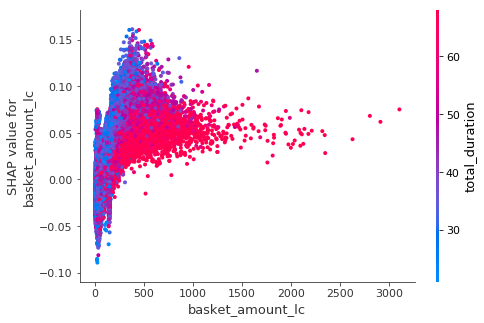

CPU times: user 37.2 s, sys: 1.5 s, total: 38.7 s
Wall time: 41.4 s


In [22]:
%%time
shap.dependence_plot(0, explanation.values, X)
#interaction_index“auto”, pick the strongest interaction

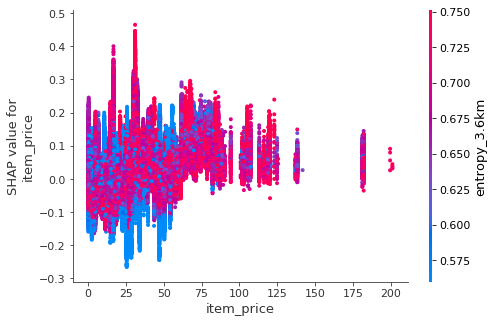

CPU times: user 31 s, sys: 685 ms, total: 31.6 s
Wall time: 31.1 s


In [25]:
%%time
shap.dependence_plot(1, explanation.values, X) 

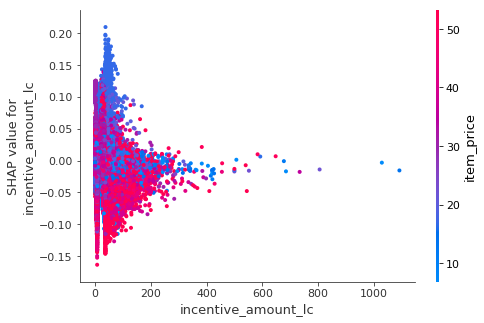

CPU times: user 30.8 s, sys: 896 ms, total: 31.7 s
Wall time: 31.2 s


In [29]:
%%time
shap.dependence_plot('incentive_amount_lc', explanation.values, X) 

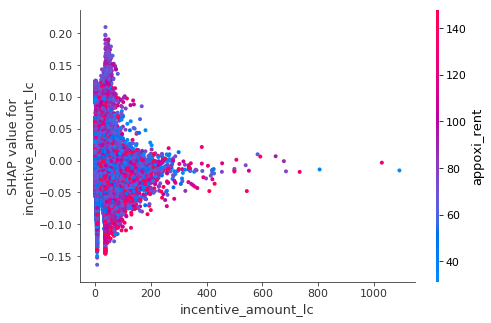

CPU times: user 28.9 s, sys: 685 ms, total: 29.5 s
Wall time: 29.1 s


In [30]:
%%time
shap.dependence_plot('incentive_amount_lc', explanation.values, X ,interaction_index='appoxi_rent') 

In [47]:
shap.dependence_plot('main_cusines', explanation.values, X) 

ValueError: Could not find feature named: main_cusines